In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
from torchtext import data, vocab
from tqdm import tqdm

sys.path.append('../')
from train_attention import *
from model_attention import *

DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # or set to 'cpu'
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

cuda:0


# Loading Enron Data

In [2]:
DATA_PATH = '../data/interim/111044_1000/'
LARGE_DATA_PATH = '../data/interim/111044/'

SAMPLE_DATA_PATH = f'{LARGE_DATA_PATH}'
# PROCESSED_DATA_PATH = f'{SAMPLE_DATA_PATH}/processed_data/'

SAVE_MODEL_PATH = '../output/'

In [3]:
# # GloVe Embedding
# from torchtext import datasets
# from collections import defaultdict

# def initialize_glove_vector(max_vectors):
#     raw_vocab = vocab.GloVe(max_vectors=max_vectors)
#     raw_vocab.itos = ['<unk>', '<pad>', '<s>', '</s>'] + raw_vocab.itos
#     raw_vocab.stoi = defaultdict(vocab._default_unk_index)
#     raw_vocab.stoi.update({tok: i for i, tok in enumerate(raw_vocab.itos)})
#     emb_size = raw_vocab.vectors.size()[1]
#     zero = torch.zeros(2, emb_size)
#     vectors = torch.cat([zero, raw_vocab.vectors])
#     raw_vocab.vectors = vectors
#     return raw_vocab

# glove_vocab_modify = initialize_glove_vector(max_vectors=20000)

In [4]:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [5]:
if True:
    import spacy
    tokenizer = data.get_tokenizer('spacy')

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenizer, 
                          lower=True, include_lengths=True, batch_first=True, 
                          unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = SRC
#     TRG = data.Field(tokenize=tokenizer, 
#                           lower=True, include_lengths=True, batch_first=True,
#                           unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)


    MAX_LEN = 500  # NOTE: we filter out a lot of sentences for speed
    trn_data_fields = [("src", SRC), ("trg", TRG)]
    train_data, valid_data, test_data = data.TabularDataset.splits(path=f'{SAMPLE_DATA_PATH}',
                                     train='train.csv', validation='val.csv', test='test.csv',
                                     format='csv', skip_header=True, fields=trn_data_fields, 
                                     filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)



    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.src, min_freq=MIN_FREQ)

# For testing glove embedding
#     train_data.fields['src'].vocab = glove_vocab_modify
#     train_data.fields['trg'].vocab = glove_vocab_modify
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

In [6]:
TRG.vocab.stoi[SOS_TOKEN]

0

In [7]:
train_data[0].src[:10]

['hello', 'vince', ',', ' ', 'my', 'name', 'is', 'bernard', 'murphy', '-']

In [8]:
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 67045
valid 19070
test 9568 

First training example:
src: hello vince ,   my name is bernard murphy - i received your e - mail address from les clewlow , who was my phd supervisor at the financia options research centre at warwick business school .   i 've just finished my phd on electricity price jump diffusions :   a theoretical and empirical study in incomplete markets - hence my interest in electricity price modelling and derivative pricing .   i was looking to get hold of a copy of your 1997 paper , which has recently come to my attention :   " the challenge of pricing & risk - managing electricity derivatives " , the us power market , risk publications , pp . 149 - 171 .   and les suggested that i contact you directly ( les is travelling at present and does n't have an electronic copy available ) to request an e - copy .   incidentally , i am lecturer in finance / financial mathematics at university of limerick ( ireland ) and hav

In [9]:
train_iter = data.BucketIterator(train_data, batch_size=60, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

In [10]:
len(SRC.vocab.itos)

32513

# Model Training

In [11]:
model = make_model(len(SRC.vocab.itos), len(TRG.vocab.itos),
                   emb_size=300, hidden_size=256,
                   num_layers=1, dropout=0.2)

dev_perplexities = train(model, train_iter, valid_iter, SRC, TRG, num_epochs=10, lr=0.0003, print_every=100)

/home/yj1461/py3.6.3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 100 Loss: 26.402468 Tokens per Sec: 3792.766632
Epoch Step: 200 Loss: 21.831011 Tokens per Sec: 3886.604453
Epoch Step: 300 Loss: 37.130886 Tokens per Sec: 3767.524120
Epoch Step: 400 Loss: 30.045364 Tokens per Sec: 3734.387767
Epoch Step: 500 Loss: 33.609913 Tokens per Sec: 3836.774301
Epoch Step: 600 Loss: 35.982204 Tokens per Sec: 3839.262433
Epoch Step: 700 Loss: 28.164364 Tokens per Sec: 3683.216624
Epoch Step: 800 Loss: 31.841702 Tokens per Sec: 3777.761926
Epoch Step: 900 Loss: 22.132233 Tokens per Sec: 3690.118849
Epoch Step: 1000 Loss: 29.664907 Tokens per Sec: 3777.156711
Epoch Step: 1100 Loss: 22.461683 Tokens per Sec: 3807.088405

Example #1
Src :  good afternoon mr. ball :   the enron corp. research group would like to conduct an informal interview with you at your convenience .   please give me some dates and times within the next 2 weeks that you might be available and i will arrange the schedule .   the people that will be interviewing you are :   vi

Validation perplexity: 51.656317
Epoch 2
Epoch Step: 100 Loss: 17.412642 Tokens per Sec: 3761.621474
Epoch Step: 200 Loss: 12.202969 Tokens per Sec: 3855.087580
Epoch Step: 300 Loss: 19.851547 Tokens per Sec: 3779.563902
Epoch Step: 400 Loss: 20.400808 Tokens per Sec: 3774.728938
Epoch Step: 500 Loss: 21.779236 Tokens per Sec: 3973.481493
Epoch Step: 600 Loss: 15.801266 Tokens per Sec: 3789.830011
Epoch Step: 700 Loss: 27.296480 Tokens per Sec: 3823.213089
Epoch Step: 800 Loss: 21.911037 Tokens per Sec: 3694.721535
Epoch Step: 900 Loss: 23.176317 Tokens per Sec: 3706.202963
Epoch Step: 1000 Loss: 14.648292 Tokens per Sec: 3840.019747
Epoch Step: 1100 Loss: 16.914032 Tokens per Sec: 3713.341663

Example #1
Src :  good afternoon mr. ball :   the enron corp. research group would like to conduct an informal interview with you at your convenience .   please give me some dates and times within the next 2 weeks that you might be available and i will arrange the schedule .   the people that wi

Example #4
Src :  all ,   attached please find the current tagg / erms project list for the user meeting tomorrow at 10 a.m. in <unk> .     thanks & regards ,   karima husain project manager , gas tactical ( 713 ) 345 - 7252
Trg :  tagg / erms project list
Pred:  / <unk> / list / <unk> / <unk>

Example #5
Src :  calendar entry : 	 appointment   description : eb3127 - will smith , duong luu   date : 		 4/24/2001 time : 		 9:00 am - 10:00 am ( central standard time )   chairperson : 	 stacey w white   detailed description :
Trg :  eb3127 - will smith , duong luu
Pred:  - cindy olson , sheila , sheila , l. blair

Validation perplexity: 35.388480
Epoch 4
Epoch Step: 100 Loss: 22.475595 Tokens per Sec: 3750.162057
Epoch Step: 200 Loss: 14.347709 Tokens per Sec: 3937.783653
Epoch Step: 300 Loss: 12.179421 Tokens per Sec: 3753.265148
Epoch Step: 400 Loss: 19.947163 Tokens per Sec: 3775.044905
Epoch Step: 500 Loss: 8.779942 Tokens per Sec: 3891.792634
Epoch Step: 600 Loss: 20.125929 Tokens per

Example #4
Src :  all ,   attached please find the current tagg / erms project list for the user meeting tomorrow at 10 a.m. in <unk> .     thanks & regards ,   karima husain project manager , gas tactical ( 713 ) 345 - 7252
Trg :  tagg / erms project list
Pred:  / project list

Example #5
Src :  calendar entry : 	 appointment   description : eb3127 - will smith , duong luu   date : 		 4/24/2001 time : 		 9:00 am - 10:00 am ( central standard time )   chairperson : 	 stacey w white   detailed description :
Trg :  eb3127 - will smith , duong luu
Pred:  - greg whalley , john , harry , harry

Validation perplexity: 31.794436
Epoch 6
Epoch Step: 100 Loss: 8.197569 Tokens per Sec: 3724.627137
Epoch Step: 200 Loss: 15.234990 Tokens per Sec: 3719.328353
Epoch Step: 300 Loss: 10.713161 Tokens per Sec: 3847.159844
Epoch Step: 400 Loss: 14.645063 Tokens per Sec: 3854.050364
Epoch Step: 500 Loss: 8.823080 Tokens per Sec: 3760.702437
Epoch Step: 600 Loss: 16.139095 Tokens per Sec: 3834.998336
Epoc

Example #4
Src :  all ,   attached please find the current tagg / erms project list for the user meeting tomorrow at 10 a.m. in <unk> .     thanks & regards ,   karima husain project manager , gas tactical ( 713 ) 345 - 7252
Trg :  tagg / erms project list
Pred:  inventory list

Example #5
Src :  calendar entry : 	 appointment   description : eb3127 - will smith , duong luu   date : 		 4/24/2001 time : 		 9:00 am - 10:00 am ( central standard time )   chairperson : 	 stacey w white   detailed description :
Trg :  eb3127 - will smith , duong luu
Pred:  - leave at 2:00

Validation perplexity: 33.935171
Epoch 8
Epoch Step: 100 Loss: 11.195764 Tokens per Sec: 3651.951120
Epoch Step: 200 Loss: 7.086837 Tokens per Sec: 3799.248851
Epoch Step: 300 Loss: 7.034146 Tokens per Sec: 3862.061715
Epoch Step: 400 Loss: 6.729391 Tokens per Sec: 3889.858742
Epoch Step: 500 Loss: 8.249287 Tokens per Sec: 3851.696150
Epoch Step: 600 Loss: 9.600771 Tokens per Sec: 3895.944090
Epoch Step: 700 Loss: 11.6263

Example #4
Src :  all ,   attached please find the current tagg / erms project list for the user meeting tomorrow at 10 a.m. in <unk> .     thanks & regards ,   karima husain project manager , gas tactical ( 713 ) 345 - 7252
Trg :  tagg / erms project list
Pred:  : project list

Example #5
Src :  calendar entry : 	 appointment   description : eb3127 - will smith , duong luu   date : 		 4/24/2001 time : 		 9:00 am - 10:00 am ( central standard time )   chairperson : 	 stacey w white   detailed description :
Trg :  eb3127 - will smith , duong luu
Pred:  - leave at eb47c2

Validation perplexity: 41.424192


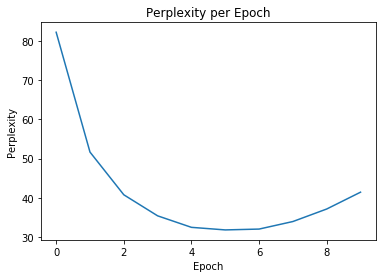

In [12]:
plot_perplexity(dev_perplexities)

In [13]:
print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
               model, n=10, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)  


Example #1
Src :  good afternoon mr. ball :   the enron corp. research group would like to conduct an informal interview with you at your convenience .   please give me some dates and times within the next 2 weeks that you might be available and i will arrange the schedule .   the people that will be interviewing you are :   vince kaminski    managing director stinson gibner    vice president grant masson    vice president vasant shanbhogue   vice president krishna krishnarao   director zimin lu    director tanya tamarchenko   manager alex huang    manager   each individual interview will last approximately 15 - 20 minutes , so we probably should allow at least   3 hours .   if you would prefer to call me with some dates and times - i can check the calendars while we are talking .   look forward to hearing from you .   thank you .   shirley crenshaw administrative coordinator research group 713/853 - 5290
Trg :  interview with enron corp. research group
Pred:  interview with enron cor

# Evaluation

In [14]:
import sacrebleu
import rouge
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/yj1461/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
references = [" ".join(example.trg) for example in valid_data]
emails = [" ".join(example.src) for example in valid_data]
print(len(references))
print(references[0])

19070
interview with enron corp. research group


Prediction:

In [16]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in tqdm(valid_iter):
    batch = rebatch(PAD_INDEX, batch)
    pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
    hypotheses.append(pred)
    alphas.append(attention)

100%|██████████| 19070/19070 [13:06<00:00, 24.26it/s]


In [17]:
hypotheses = [" ".join(lookup_words(x, TRG.vocab)) for x in hypotheses]
# hypotheses = [" ".join(x) for x in hypotheses]

In [18]:
print(emails[0])
print(references[0])
print(hypotheses[0])

good afternoon mr. ball :   the enron corp. research group would like to conduct an informal interview with you at your convenience .   please give me some dates and times within the next 2 weeks that you might be available and i will arrange the schedule .   the people that will be interviewing you are :   vince kaminski    managing director stinson gibner    vice president grant masson    vice president vasant shanbhogue   vice president krishna krishnarao   director zimin lu    director tanya tamarchenko   manager alex huang    manager   each individual interview will last approximately 15 - 20 minutes , so we probably should allow at least   3 hours .   if you would prefer to call me with some dates and times - i can check the calendars while we are talking .   look forward to hearing from you .   thank you .   shirley crenshaw administrative coordinator research group 713/853 - 5290
interview with enron corp. research group
interview with enron corp.


## BLEU

In [19]:
!pip install sacrebleu

In [20]:
import sacrebleu

In [ ]:
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

## Rouge

In [ ]:
!pip install py-rouge nltk

In [ ]:
import rouge
import nltk
nltk.download('punkt')

In [ ]:
hyps, refs = references, hypotheses

In [ ]:
def prepare_results(p, r, f):
    return '\t{}:\t{}: {:5.2f}\t{}: {:5.2f}\t{}: {:5.2f}'.format(metric, 'P', 100.0 * p, 'R', 100.0 * r, 'F1', 100.0 * f)


for aggregator in ['Avg']: #'Best', 'Individual'
    print('Evaluation with {}'.format(aggregator))
    apply_avg = aggregator == 'Avg'
    apply_best = aggregator == 'Best'

    evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg=apply_avg,
                           apply_best=apply_best,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

    all_hypothesis = hyps
    all_references = refs

    scores = evaluator.get_scores(all_hypothesis, all_references)

    for metric, results in sorted(scores.items(), key=lambda x: x[0]):
        if not apply_avg and not apply_best: # value is a type of list as we evaluate each summary vs each reference
            for hypothesis_id, results_per_ref in enumerate(results):
                nb_references = len(results_per_ref['p'])
### skipp printing for individual rouge
#                 for reference_id in range(nb_references):
#                     print('\tHypothesis #{} & Reference #{}: '.format(hypothesis_id, reference_id))
#                     print('\t' + prepare_results(results_per_ref['p'][reference_id], results_per_ref['r'][reference_id], results_per_ref['f'][reference_id]))
            print()
        else:
            print(prepare_results(results['p'], results['r'], results['f']))
    print()

### Saving resulting data and model for future reference

In [ ]:
evalf1 = scores['rouge-1']['f']
str(evalf1)[:6]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame([emails, references, hypotheses], index=['source','reference','hypotheses']).T

In [ ]:
df.to_csv(SAVE_MODEL_PATH+str(evalf1)[:6]+'.csv', index=False)

In [ ]:
torch.save(model, SAVE_MODEL_PATH+str(evalf1)[:6]+'.pt')